In [1]:
import ausweather
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
dts = {}
for m in range(1, 13):
    t = pd.Timestamp(f"2000-{m:02.0f}-01")
    dts[t.strftime("%b")] = t

In [3]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 150

- 23005 glen osmond
- 23720 hahndorf
- 26021 mount gambier
- 23710 clarendon
- 23005 Glen Osmond
- 17004 Anna Creek

In [26]:
st = ausweather.fetch_bom_station_from_silo(23005, "kinverarity@hotmail.com", query_from="1920-01-01")

station #: 23005 name: ADELAIDE (GLEN OSMOND) title: 23005 ADELAIDE (GLEN OSMOND) (fetched from SILO on 2020-04-30 13:15:21.703412)


In [27]:
st.keys()

dict_keys(['silo_returned', 'station_no', 'station_name', 'title', 'df', 'annual', 'srn'])

In [28]:
df = st["df"][["Date", "Rain", "Srn"]]

In [29]:
df.loc[:, "dayn"] = df.Date.dt.dayofyear
df.loc[:, "year"] = df.Date.dt.year
df.loc[:, "month"] = df.Date.dt.month
df.loc[:, "rain_ycum"] = df.groupby("year").Rain.cumsum()

In [30]:
# df.loc[df.Srn.isin([25, 35, 75]), "Srn"] = pd.np.nan
df = df.dropna(subset=["Srn"])

In [31]:
year_min = df.Date.min().strftime("%Y")
year_max = df.Date.max().strftime("%a %d %b %Y")
print(year_max)

Wed 29 Apr 2020


In [32]:
def pick_years(t):
    t = t.sort_values("rain_ycum")
    return pd.Series({
        "year_min": t.year.values[0],
        "year_max": t.year.values[-1]
    })

In [33]:
cumulative_ranks = {}
for year in set(df.year.unique()):
    cumulative_ranks[year] = 0
    
for dayn, ddf in df.groupby("dayn"):
    ddf = ddf.sort_values("rain_ycum")
    ddf["rank"] = range(len(ddf))
    ddf["rank"] = (ddf["rank"] - (len(ddf) / 2)) ** 5
    ddf = ddf.set_index("year")
    for year in ddf.index.values:
        r = ddf.loc[year]["rank"]
        cumulative_ranks[year] += r

In [34]:
cumranks = pd.Series(cumulative_ranks).sort_values()

In [35]:
cumranks.sort_values()

1959   -7.027321e+10
1965   -6.277306e+10
1967   -6.239436e+10
1930   -4.328961e+10
1957   -3.779030e+10
            ...     
1973    4.005310e+10
1923    4.503524e+10
1968    4.508815e+10
1932    4.803115e+10
1971    5.959673e+10
Length: 101, dtype: float64

In [36]:
dayn_df = df.groupby("dayn").rain_ycum.describe(percentiles=(0.03, 0.1, 0.3, 0.7, 0.9, 0.97))

In [37]:
dayn_df

,count,mean,std,min,3%,10%,30%,50%,70%,90%,97%,max
dayn,,,,,,,,,,,,
1,101.0,0.800000,4.143380,0.0,0.000,0.00,0.00,0.00,0.00,0.10,7.000,30.4
2,101.0,2.389109,7.125769,0.0,0.000,0.00,0.00,0.00,0.00,7.60,23.400,39.1
3,101.0,2.654455,7.357466,0.0,0.000,0.00,0.00,0.00,0.20,7.60,23.400,39.1
4,101.0,3.373267,7.916930,0.0,0.000,0.00,0.00,0.00,1.40,8.40,30.000,39.1
5,101.0,4.031683,8.193326,0.0,0.000,0.00,0.00,0.00,3.00,12.40,30.000,39.1
6,101.0,4.700000,9.117247,0.0,0.000,0.00,0.00,0.20,3.60,14.20,35.000,42.9
7,101.0,5.457426,10.555893,0.0,0.000,0.00,0.00,0.30,4.30,15.40,35.000,64.2
8,101.0,6.152475,10.999542,0.0,0.000,0.00,0.00,0.80,5.40,19.10,35.000,67.2
9,101.0,6.500000,11.115143,0.0,0.000,0.00,0.00,1.50,5.80,19.10,35.800,67.2


In [38]:
year_dayn_lims = df.groupby("dayn").apply(pick_years)

In [39]:
year_mins = year_dayn_lims.year_min.value_counts()
year_maxs = year_dayn_lims.year_max.value_counts()

In [40]:
label_min_years = year_mins[year_mins >= 50]
label_max_years = year_maxs[year_maxs >= 50]

In [41]:
label_years = set(list(label_min_years.index) + list(label_max_years.index) + [2019, 2020])
non_label_years = set(df.year.unique()) - label_years

In [42]:
ann = df[df != 2020].groupby("year").Rain.sum().describe(percentiles=(0.03, 0.1, 0.3, 0.5, 0.7, 0.9, 0.97))

In [43]:
dayn_df.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            357, 358, 359, 360, 361, 362, 363, 364, 365, 366],
           dtype='int64', name='dayn', length=366)

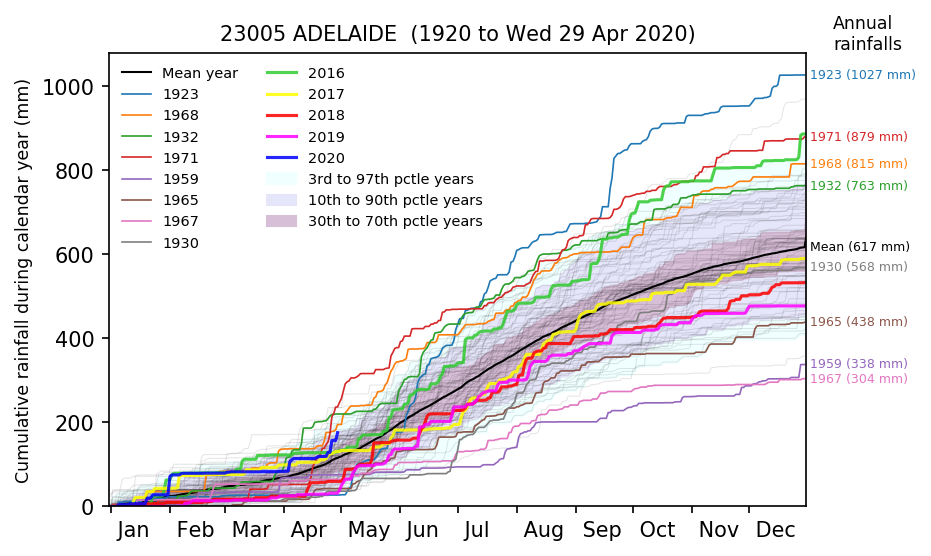

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
for year in non_label_years:
    idx = df.year == year
    ax.plot(df.loc[idx, "dayn"], df.loc[idx, "rain_ycum"], lw=0.5, color="k", alpha=0.1)
ax.fill_between(dayn_df.index, dayn_df["3%"], dayn_df["97%"], color="azure", lw=1, label="3rd to 97th pctle years", alpha=1)
ax.fill_between(dayn_df.index, dayn_df["10%"], dayn_df["90%"], color="lavender", lw=1, label="10th to 90th pctle years", alpha=1)
ax.fill_between(dayn_df.index, dayn_df["30%"], dayn_df["70%"], color="thistle", lw=1, label="30th to 70th pctle years", alpha=1)
ax.plot(dayn_df.index.values, dayn_df["mean"], color="k", lw=1, label="Mean year")
label_values = pd.np.array([ann['mean']])
texts = [
    lambda y, v, c: ax.text(366, v, f" {y} ({ann['mean']:.0f} mm)", ha="left", va="center", fontsize=6, color=c)
]
colours = ["k"]
text_years = list(cumranks[-4:].index) + list(cumranks[:4].index)
for year in text_years:
    idx = df.year == year
    y = df.loc[idx, "rain_ycum"]
    value = y.iloc[-1]
    line, = ax.plot(df.loc[idx, "dayn"], y, lw=0.8, label=str(year))
    colours.append(line.get_color())
    for i in range(5000):
        diffs = label_values - value
        adiffs = abs(diffs)
        j = pd.np.argmin(adiffs)
        if adiffs[j] > 22:
            break
        else:
            if diffs[j] >= 0:
                label_values[j] += 2
                value -= 2
            else:
                label_values[j] -= 2
                value += 2
    texts.append(
        lambda y, v, c: ax.text(366, v, f" {y} ({v:.0f} mm)", ha="left", va="center", fontsize=6, color=c)
    )
    label_values = pd.np.append(label_values, value)

year_colours = {2016: "limegreen", 2017: "yellow", 2018: "red", 2019: "magenta", 2020: "blue"}
for year in year_colours.keys():
    ax.plot(df.loc[df.year == year, "dayn"], df.loc[df.year == year, "rain_ycum"], 
            label=str(year), color=year_colours[year], lw=1.5, alpha=0.85)

ax.set_xlim(0, 366)
ax.set_ylim(0, None)
ax.legend(loc="upper left", fontsize="x-small", frameon=False, ncol=2)
ax.set_ylabel("Cumulative rainfall during calendar year (mm)", size="small")
ax.set_title(st['title'].split("(")[0] + f" ({year_min} to {year_max})", size="medium")
text_labels = ["Mean"] + text_years
for i in range(len(label_values)):
    texts[i](text_labels[i], label_values[i], colours[i])
y0, y1 = ax.get_ylim()
yr = y1 - y0
ax.text(380, y1, "Annual\nrainfalls", va="bottom", ha="left", fontsize="small")
xts = [t.dayofyear for t in dts.values()]
xtlabels = [" " + tk for tk in dts.keys()]
_ = ax.set_xticks(xts)
_ = ax.set_xticklabels(xtlabels, ha="left")
fig.savefig(f"cumulative_rainfall_{st['title'].split('(')[0][6:]}_example.png", dpi=150)